## Exploration and clustering of the neighborhoods in Toronto.

#### Fistly, we will import everything we might need

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt  
from matplotlib import style 

import json

!conda install -c conda-forge geopy --yes,

from geopy.geocoders import Nominatim
import geocoder

import requests
from pandas.io.json import json_normalize

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes
import folium

print('Libraries imported.')

usage: conda [-h] [-V] command ...
conda: error: unrecognized arguments: --yes,


OSError: [Errno 23] Too many open files in system: '/Users/yevhentarasov/opt/anaconda3/lib/python3.7/site-packages/geopy/util.py'

# Part 1

#### Then we should fetch data from <a link='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'> Wikipedia</a> with PostalCode, Borough, and Neighborhood

In [66]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
lst = pd.read_html(url)

In [67]:
df=pd.DataFrame(lst[0])

The dataframe will consist of three columns: PostalCode, Borough, and Neighborhood

In [68]:
df.head()

,Postal Code,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.

In [69]:
df = df.drop(df[df['Borough']=='Not assigned'].index)

In [70]:
df.head()

,Postal Code,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


More than one neighborhood can exist in one postal code area. For example, in the table on the Wikipedia page, you will notice that M5A is listed twice and has two neighborhoods: Harbourfront and Regent Park. These two rows will be combined into one row with the neighborhoods separated with a comma.

In [71]:
df = df.groupby('Postal Code').agg({'Borough': list,'Neighborhood': list})
df = df.reset_index()
df['Neighborhood'] = df['Neighborhood'].apply(lambda x: ','.join(x))
df['Borough'] = df['Borough'].apply(lambda x: ','.join(x))                                     

In [72]:
df.head()

,Postal Code,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [73]:
df.shape

(103, 3)

# Part 2

### Next we should get geodata of neighborhoods above
I did try to use geocoder commented below but it did not work on my machine nor on Watson Studio.

So we gonna use cvs-file with coordinates applied in out task.

In [74]:
coords = pd.read_csv('Geospatial_Coordinates.csv')

In [75]:
coords.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [76]:
df = pd.merge(df, coords, on='Postal Code')

In [77]:
df.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


We have got data with PC, Borough, Neighborhood, and coordinates.
Now will narrow this dataset to boroughs that contain 'Toronto' in their name

In [78]:
df = df[df['Borough'].str.contains('Toronto')]
df = df.reset_index(drop=True, inplace=True)
df.head()

# Part 3

### Now we will start out exploration of Toronto, Canada

Firslty, let's get Toronto coordinates and make a map of the city with all nieghtborhoods we got above

In [17]:
pip install geopy[aiohttp]

Note: you may need to restart the kernel to use updated packages.


We have used Async mode of GeoPy because regular one appears to be picky bastard that does not want to work properly on my machine.

In [103]:
from geopy.adapters import AioHTTPAdapter
from geopy.geocoders import Nominatim

async with Nominatim(
    user_agent="canada_explorer",
    adapter_factory=AioHTTPAdapter,
) as geolocator:
    location = await geolocator.geocode("Toronto, Canada")
print('The geograpical coordinate of Toronto are {}, {}.'.format(location.latitude, location.longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


We have got coordinates of Toronto to make a map

In [104]:
map_toronto = folium.Map(location=[location.latitude, location.longitude], zoom_start=11)

for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

To get info about venues in each neighborhood we should use Foursquere API

In [105]:
CLIENT_ID = 'ZZS0AL4NN4QA4KHMVFRTI4VNSRPG0AQKBK5Q5UTF4YHEYUCO'
CLIENT_SECRET = 'FA2HSAEYTUJ2NWTOWIRCXSMVWZ4E2VBKZPOBBTVE4QAAHQQT'
VERSION = '20180605'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ZZS0AL4NN4QA4KHMVFRTI4VNSRPG0AQKBK5Q5UTF4YHEYUCO
CLIENT_SECRET:FA2HSAEYTUJ2NWTOWIRCXSMVWZ4E2VBKZPOBBTVE4QAAHQQT


Next we should define functions to get information about neighborhoods/venues from Foursquere

In [106]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [107]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000, LIMIT = 100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [108]:
toronto_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

The Beaches
The Danforth West, Riverdale
India Bazaar, The Beaches West
Studio District
Lawrence Park
Davisville North
North Toronto West, Lawrence Park
Davisville
Moore Park, Summerhill East
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
Rosedale
St. James Town, Cabbagetown
Church and Wellesley
Regent Park, Harbourfront
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Richmond, Adelaide, King
Harbourfront East, Union Station, Toronto Islands
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North & West, Forest Hill Road Park
The Annex, North Midtown, Yorkville
University of Toronto, Harbord
Kensington Market, Chinatown, Grange Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Stn A PO Boxes
First Canadian Place, Underground city
Christie
Dufferin, Dovercourt Village
Little Portugal, Trinity
Brockton, Parkdale Village, Exhibition Place
High 

Let's look what we got

In [109]:
print(toronto_venues.shape)
toronto_venues.head()

(3189, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,The Beaches,43.676357,-79.293031,Tori's Bakeshop,43.672114,-79.290331,Vegetarian / Vegan Restaurant
2,The Beaches,43.676357,-79.293031,Beaches Bake Shop,43.680363,-79.289692,Bakery
3,The Beaches,43.676357,-79.293031,The Beech Tree,43.680493,-79.288846,Gastropub
4,The Beaches,43.676357,-79.293031,Ed's Real Scoop,43.672630,-79.287993,Ice Cream Shop


In [110]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,100,100,100,100,100,100
"Brockton, Parkdale Village, Exhibition Place",100,100,100,100,100,100
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",49,49,49,49,49,49
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",14,14,14,14,14,14
Central Bay Street,100,100,100,100,100,100
Christie,100,100,100,100,100,100
Church and Wellesley,100,100,100,100,100,100
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
Davisville,100,100,100,100,100,100


In [111]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 276 uniques categories.


Clustering models can not procces words thus we should transform venues data inro corresponings dummies dataset

In [112]:
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Zoo,Accessories Store,Airport,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Art Gallery,Art Museum,...,Turkish Restaurant,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [113]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Zoo,Accessories Store,Airport,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Art Gallery,...,Turkish Restaurant,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Women's Store,Yoga Studio
0,Berczy Park,0.0,0.00,0.000000,0.010000,0.0,0.0,0.0,0.0,0.01,...,0.0,0.00,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.00
1,"Brockton, Parkdale Village, Exhibition Place",0.0,0.01,0.000000,0.010000,0.0,0.0,0.0,0.0,0.01,...,0.0,0.00,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.00
2,"Business reply mail Processing Centre, South C...",0.0,0.00,0.000000,0.020408,0.0,0.0,0.0,0.0,0.00,...,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.0,0.00,0.071429,0.000000,0.0,0.0,0.0,0.0,0.00,...,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00
4,Central Bay Street,0.0,0.00,0.000000,0.010000,0.0,0.0,0.0,0.0,0.02,...,0.0,0.01,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.02


Too explore our data let's get top 5 venues in each neighborhood

In [114]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berczy Park----
                 venue  freq
0          Coffee Shop  0.12
1                 Café  0.06
2                Hotel  0.05
3  Japanese Restaurant  0.05
4           Restaurant  0.05


----Brockton, Parkdale Village, Exhibition Place----
                    venue  freq
0                    Café  0.07
1              Restaurant  0.06
2             Coffee Shop  0.06
3                     Bar  0.05
4  Furniture / Home Store  0.04


----Business reply mail Processing Centre, South Central Letter Processing Plant Toronto----
                  venue  freq
0                  Park  0.10
1           Coffee Shop  0.08
2           Pizza Place  0.06
3               Brewery  0.06
4  Fast Food Restaurant  0.04


----CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport----
             venue  freq
0             Café  0.14
1  Harbor / Marina  0.14
2      Coffee Shop  0.14
3           Garden  0.07
4             Park  0.07


----Central Bay

For conviniance we will create a dataframe with 10 most popular venue types in each neighborhood

In [115]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [116]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Café,Hotel,Japanese Restaurant,Restaurant,Park,Bakery,Creperie,Grocery Store,Seafood Restaurant
1,"Brockton, Parkdale Village, Exhibition Place",Café,Coffee Shop,Restaurant,Bar,Bakery,Furniture / Home Store,Tibetan Restaurant,Gift Shop,Performing Arts Venue,Italian Restaurant
2,"Business reply mail Processing Centre, South C...",Park,Coffee Shop,Pizza Place,Brewery,Fast Food Restaurant,Burrito Place,Bakery,Italian Restaurant,Sushi Restaurant,Grocery Store
3,"CN Tower, King and Spadina, Railway Lands, Har...",Harbor / Marina,Café,Coffee Shop,Garden,Track,Scenic Lookout,Sculpture Garden,Dance Studio,Dog Run,Park
4,Central Bay Street,Coffee Shop,Park,Café,Diner,Pizza Place,Sushi Restaurant,Bubble Tea Shop,Burrito Place,Ramen Restaurant,Plaza


Now we should apply KMean algorithm to cluster out neighborhood.\
First of all, lets define most suitable k for our dataset using elbow method

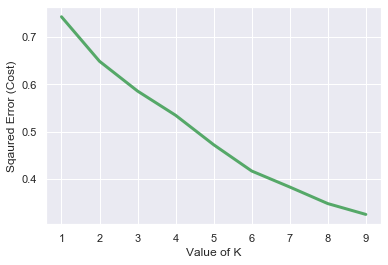

In [153]:
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

cost =[] 
for i in range(1, 10): 
    KM = KMeans(n_clusters = i, max_iter = 100, random_state=0) 
    KM.fit(toronto_grouped_clustering) 
      
    cost.append(KM.inertia_)      
  
plt.plot(range(1, 10), cost, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.show()

We can see that there is no obvious breaking point.\
So we will chose k as 6 as one that breaks line the most

In [156]:
clusterNum = 6
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
k_means.fit(toronto_grouped_clustering)
labels_k = k_means.labels_

Then we will asign Claster labels to each neighborhood

In [ ]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', labels_k)

toronto_merged = df

toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

And will map it

In [155]:
map_clusters = folium.Map(location=[location.latitude, location.longitude], zoom_start=12)

x = np.arange(clusterNum)
ys = [i + x + (i*x)**2 for i in range(clusterNum)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color = rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Now let's explore clusters one by one

1st cluster

In [141]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1,2] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,Downtown Toronto,St. James Town,0,Coffee Shop,Café,Restaurant,Italian Restaurant,Cosmetics Shop,Seafood Restaurant,Hotel,Japanese Restaurant,Gastropub,Plaza
16,Downtown Toronto,Berczy Park,0,Coffee Shop,Café,Hotel,Japanese Restaurant,Restaurant,Park,Bakery,Creperie,Grocery Store,Seafood Restaurant
18,Downtown Toronto,"Richmond, Adelaide, King",0,Coffee Shop,Hotel,Café,Theater,Gym,Restaurant,Tea Room,Art Gallery,Arts & Crafts Store,Italian Restaurant
19,Downtown Toronto,"Harbourfront East, Union Station, Toronto Islands",0,Coffee Shop,Café,Hotel,Park,Gym,Brewery,Theater,Restaurant,Plaza,Pizza Place
20,Downtown Toronto,"Toronto Dominion Centre, Design Exchange",0,Coffee Shop,Café,Hotel,Japanese Restaurant,Restaurant,Theater,Concert Hall,Seafood Restaurant,Park,Plaza
21,Downtown Toronto,"Commerce Court, Victoria Hotel",0,Coffee Shop,Hotel,Café,Restaurant,Japanese Restaurant,Concert Hall,Gym,Beer Bar,Park,Bakery
28,Downtown Toronto,Stn A PO Boxes,0,Coffee Shop,Restaurant,Café,Hotel,Japanese Restaurant,Beer Bar,Seafood Restaurant,Art Gallery,Gym,Gastropub
29,Downtown Toronto,"First Canadian Place, Underground city",0,Coffee Shop,Hotel,Café,Restaurant,Concert Hall,Japanese Restaurant,Theater,Monument / Landmark,Plaza,Seafood Restaurant


2nd cluster

In [140]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1,2] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,East Toronto,The Beaches,1,Coffee Shop,Pizza Place,Pub,Beach,Breakfast Spot,Bakery,Japanese Restaurant,Tea Room,Bar,Burger Joint
1,East Toronto,"The Danforth West, Riverdale",1,Greek Restaurant,Café,Coffee Shop,Pub,Bank,Italian Restaurant,Fast Food Restaurant,Discount Store,Restaurant,Ramen Restaurant
2,East Toronto,"India Bazaar, The Beaches West",1,Indian Restaurant,Coffee Shop,Café,Beach,Restaurant,Brewery,Burrito Place,Fast Food Restaurant,Sandwich Place,Bakery
24,Central Toronto,"The Annex, North Midtown, Yorkville",1,Café,Italian Restaurant,Vegetarian / Vegan Restaurant,Coffee Shop,Gym,Museum,Restaurant,Pub,Bakery,Grocery Store
30,Downtown Toronto,Christie,1,Korean Restaurant,Café,Coffee Shop,Grocery Store,Mexican Restaurant,Cocktail Bar,Park,Ethiopian Restaurant,Pizza Place,Diner
35,West Toronto,"Parkdale, Roncesvalles",1,Coffee Shop,Sushi Restaurant,Bar,Café,Breakfast Spot,Pizza Place,Eastern European Restaurant,Pub,Bakery,Thai Restaurant
36,West Toronto,"Runnymede, Swansea",1,Coffee Shop,Café,Pizza Place,Bakery,Italian Restaurant,Pub,Restaurant,Bank,Falafel Restaurant,Sushi Restaurant


3rdcluster

In [142]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1,2] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Central Toronto,Davisville North,2,Coffee Shop,Italian Restaurant,Café,Restaurant,Gym,Fast Food Restaurant,Sushi Restaurant,Pizza Place,Dessert Shop,Diner
6,Central Toronto,"North Toronto West, Lawrence Park",2,Coffee Shop,Italian Restaurant,Park,Café,Sporting Goods Shop,Skating Rink,Diner,Mexican Restaurant,Restaurant,Deli / Bodega
7,Central Toronto,Davisville,2,Italian Restaurant,Coffee Shop,Sushi Restaurant,Café,Gym,Pizza Place,Restaurant,Fast Food Restaurant,Indian Restaurant,Dessert Shop
8,Central Toronto,"Moore Park, Summerhill East",2,Coffee Shop,Grocery Store,Italian Restaurant,Thai Restaurant,Park,Sushi Restaurant,Gym,Pizza Place,Bagel Shop,Café
9,Central Toronto,"Summerhill West, Rathnelly, South Hill, Forest...",2,Coffee Shop,Sushi Restaurant,Thai Restaurant,Italian Restaurant,Grocery Store,Park,Gym,Spa,Bagel Shop,Restaurant
10,Downtown Toronto,Rosedale,2,Coffee Shop,Park,Grocery Store,Breakfast Spot,BBQ Joint,Convenience Store,Playground,Sandwich Place,Candy Store,Metro Station
11,Downtown Toronto,"St. James Town, Cabbagetown",2,Coffee Shop,Café,Park,Gastropub,Japanese Restaurant,Botanical Garden,Bakery,Pub,Dance Studio,Sushi Restaurant
12,Downtown Toronto,Church and Wellesley,2,Coffee Shop,Park,Japanese Restaurant,Men's Store,Diner,Italian Restaurant,Ice Cream Shop,Pizza Place,Bookstore,Clothing Store
13,Downtown Toronto,"Regent Park, Harbourfront",2,Coffee Shop,Theater,Café,Pub,Park,Diner,Bakery,Breakfast Spot,Restaurant,Italian Restaurant
14,Downtown Toronto,"Garden District, Ryerson",2,Coffee Shop,Japanese Restaurant,Gastropub,Italian Restaurant,Pizza Place,Cosmetics Shop,Diner,Middle Eastern Restaurant,Creperie,Seafood Restaurant


4th cluster

In [143]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1,2] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,East Toronto,Studio District,3,Coffee Shop,Bar,Café,Vietnamese Restaurant,American Restaurant,Diner,Bakery,Brewery,Italian Restaurant,French Restaurant
25,Downtown Toronto,"University of Toronto, Harbord",3,Café,Bakery,Coffee Shop,Bar,Vegetarian / Vegan Restaurant,Restaurant,Beer Bar,Mexican Restaurant,Bookstore,Japanese Restaurant
26,Downtown Toronto,"Kensington Market, Chinatown, Grange Park",3,Café,Vegetarian / Vegan Restaurant,Coffee Shop,Bar,Yoga Studio,Bakery,Mexican Restaurant,Art Gallery,Arts & Crafts Store,Beer Bar
31,West Toronto,"Dufferin, Dovercourt Village",3,Café,Coffee Shop,Park,Bakery,Italian Restaurant,Sushi Restaurant,Bar,Gourmet Shop,Pharmacy,Portuguese Restaurant
32,West Toronto,"Little Portugal, Trinity",3,Café,Bar,Restaurant,Vegetarian / Vegan Restaurant,Bakery,Asian Restaurant,Cocktail Bar,Italian Restaurant,Pizza Place,Park
33,West Toronto,"Brockton, Parkdale Village, Exhibition Place",3,Café,Coffee Shop,Restaurant,Bar,Bakery,Furniture / Home Store,Tibetan Restaurant,Gift Shop,Performing Arts Venue,Italian Restaurant
34,West Toronto,"High Park, The Junction South",3,Café,Bar,Coffee Shop,Italian Restaurant,Thai Restaurant,Sushi Restaurant,Convenience Store,Park,Restaurant,Discount Store


5th cluster

In [144]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1,2] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Central Toronto,Lawrence Park,4,Park,Bookstore,College Quad,Gym / Fitness Center,Café,College Gym,Coffee Shop,Trail,Yoga Studio,Dive Bar


6th cluster

In [145]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 5, toronto_merged.columns[[1,2] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
27,Downtown Toronto,"CN Tower, King and Spadina, Railway Lands, Har...",5,Harbor / Marina,Café,Coffee Shop,Garden,Track,Scenic Lookout,Sculpture Garden,Dance Studio,Dog Run,Park
